In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

In [2]:
from sqlalchemy import create_engine
import pandas as pd

In [3]:
from astropy.table import Table
from astropy.io import fits

In [4]:
from astropy.nddata import Cutout2D

In [5]:
import gc

In [6]:
def custom_histogram(vector, bins=None, cumulative=False, errors=False):
    if bins is None:
        hh = np.histogram(vector)
    else: 
        hh = np.histogram(vector, bins=bins)
    dx = hh[1][1] - hh[1][0]
    x_bins = hh[1][:-1] + dx

    if cumulative is True:
        vals = [sum(hh[0][:i+1]) for i, _ in enumerate(hh[0])]
        if errors:
            err = np.sqrt(hh[0])
            return x_bins, vals, err
        return x_bins, vals

    elif cumulative == -1:
        vals = [sum(hh[0][i:]) for i, _ in enumerate(hh[0])]
        if errors:
            err = np.sqrt(hh[0])
            return x_bins, vals, err
        return x_bins, vals
    
    else:
        if errors:
            err = np.sqrt(hh[0])
            return x_bins, hh[0], err
        
        return x_bins, hh[0]

In [7]:
engine = create_engine('sqlite:///../RBpipeline/rbogus-dev.db')

In [8]:
simulated = pd.read_sql_query("""SELECT * FROM Simulated""", engine)

In [9]:
sim_images = pd.read_sql_table('Images', engine)

In [10]:
positives = []
# negatives = []
randoms   = []

for sim_image in sim_images.itertuples():
    cat = simulated[simulated['simage_id']==int(sim_image.id)]
    
    imgpath = sim_image.path.strip('diff.fits')+'s_diff.fits'
    img = fits.open(imgpath, memmap=False)
    pxdata = img[0].data.copy()
    img.close()
    normalized = pxdata/np.std(pxdata)
    for obj in cat.itertuples():
        x = obj.x #int(np.round(obj.x))
        y = obj.y #int(np.round(obj.y))
        if x>1023. or y>1023. or x<0. or y<0.:
            continue
            
        positives.append(Cutout2D(normalized, (x, y), size=(20,20)))
        xr, yr = np.random.randint(low=20, high=1004, size=2)
        randoms.append(Cutout2D(normalized, (xr, yr), size=(20,20)))
    
    gc.collect()

In [11]:
positives = np.asarray(positives)
patches_pos = np.zeros((len(positives), 20, 20))
for i, elem in enumerate(positives):
    dx, dy = elem.data.shape
    patches_pos[i, :dx, :dy] = elem.data

del(positives)    
gc.collect()

randoms = np.asarray(randoms)
patches_rnd = np.zeros((len(randoms), 20, 20))
for i, elem in enumerate(randoms):
    dx, dy = elem.data.shape
    patches_rnd[i, :dx, :dy] = elem.data
del(randoms)
gc.collect()

0

(array([  1.30000000e+02,   2.12485180e+07,   7.85300000e+03,
          1.27400000e+03,   5.41000000e+02,   2.83000000e+02,
          1.11000000e+02,   5.30000000e+01,   2.80000000e+01,
          9.00000000e+00]),
 array([ -43.57725521,  -16.03756998,   11.50211524,   39.04180047,
          66.58148569,   94.12117092,  121.66085615,  149.20054137,
         176.7402266 ,  204.27991183,  231.81959705]),
 <a list of 10 Patch objects>)

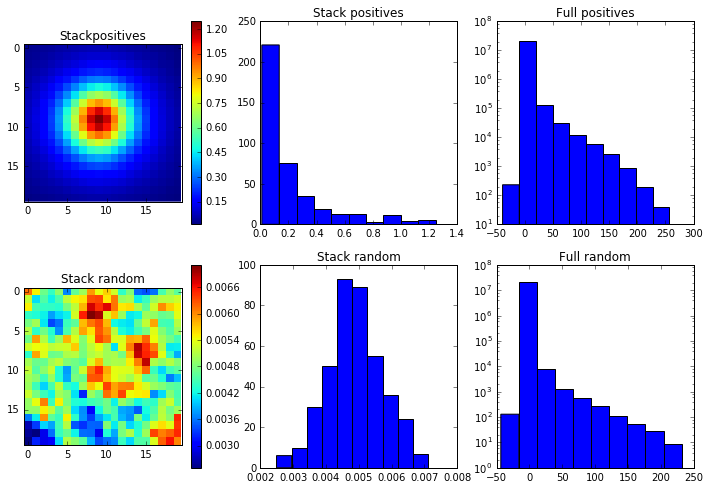

In [12]:
stack_pos = np.median(patches_pos, axis=0)
gc.collect()
stack_rnd = np.median(patches_rnd, axis=0)
gc.collect()

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Stackpositives')
plt.imshow(stack_pos, interpolation='none')
plt.colorbar()
plt.subplot(234)
plt.title('Stack random')
plt.imshow(stack_rnd, interpolation='none')
plt.colorbar()
plt.subplot(232)
plt.title('Stack positives')
plt.hist(stack_pos.flatten(), log=False)
plt.subplot(235)
plt.title('Stack random')
plt.hist(stack_rnd.flatten(), log=False)
plt.subplot(233)
plt.title('Full positives')
plt.hist(patches_pos.flatten(), log=True)
plt.subplot(236)
plt.title('Full random')
plt.hist(patches_rnd.flatten(), log=True)


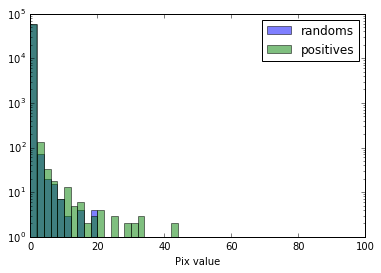

In [51]:
bins = np.arange(0., 100., 2)
plt.hist(np.array(randoms), label='randoms', log=True, bins=bins, alpha=0.5)
plt.hist(np.array(positives), label='positives', log=True, bins=bins, alpha=0.5)
plt.legend(loc='best')
plt.xlabel('Pix value')